In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Zxcvbnm@321',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:\Ecommer Python and Sql Project\Target Sales Dataset-20251031T141200Z-1-001\Target Sales Dataset'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
db = mysql.connector.connect(host='localhost',username='root',password='Zxcvbnm@321',database='ecommerce')

cur= db.cursor()



1. List all unique cities where customers are located.

In [3]:
query = "select distinct customer_city from customers"

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [4]:
query = "select count(order_id)  from orders where year(order_purchase_timestamp)=2017"

cur.execute(query)

data=cur.fetchall()

"Total Orders",data[0][0]

('Total Orders', 270606)

Find the total sales per category.

In [5]:
query = """SELECT UPPER(products.product_category) AS category,
       ROUND(SUM(payments.payment_value),2) AS sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category;
          """

cur.execute(query)

data=cur.fetchall()

data

df = pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,1.094556e+08
1,FURNITURE DECORATION,3.089181e+08
2,TELEPHONY,1.051665e+08
3,BED TABLE BATH,3.699116e+08
4,AUTOMOTIVE,1.840956e+08
...,...,...
69,CDS MUSIC DVDS,2.590769e+05
70,LA CUISINE,6.293225e+05
71,FASHION CHILDREN'S CLOTHING,1.697047e+05
72,PC GAMER,4.696769e+05


4. Calculate the percentage of orders that were paid in installments.

In [6]:
query = """select (sum(case when payment_installments >=1 then 1
else 0 end))/count(*)*100 from payments"""

cur.execute(query)

data=cur.fetchall()

data


[(Decimal('99.9981'),)]

5. Count the number of customers from each state.

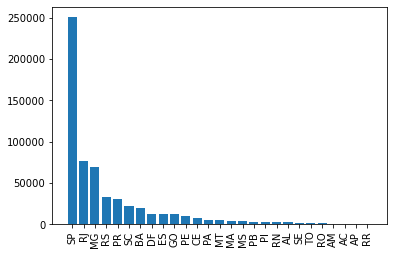

<Figure size 1440x288 with 0 Axes>

In [7]:
query = """SELECT customer_state, count(customer_id)
from customers
group by customer_state"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['states','customer_count'])
df=df.sort_values(by='customer_count',ascending=False)


import matplotlib.pyplot as plt

plt.bar(df['states'],df['customer_count'])

plt.xticks(rotation=90)
plt.figure(figsize=(20,4))
plt.show()


1. Calculate the number of orders per month in 2018.


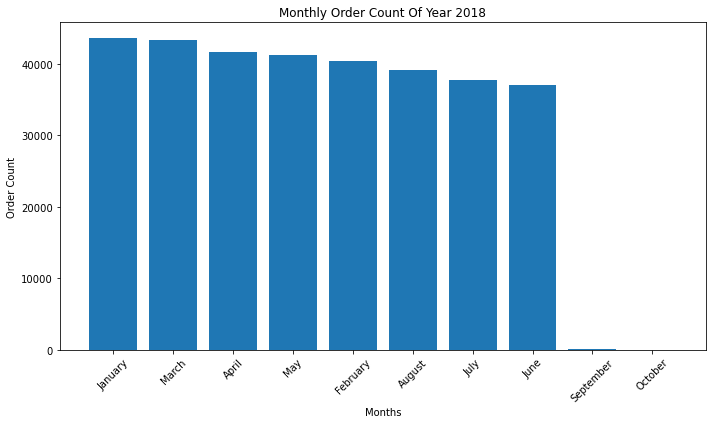

In [8]:
query = """select monthname(order_purchase_timestamp) month ,count(order_id) order_count
from orders where year(order_purchase_timestamp)=2018
group by month"""

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Months','Order_Count'])
df=df.sort_values(by='Order_Count',ascending=False)


plt.figure(figsize=(10, 6))
plt.bar(df['Months'],df['Order_Count'])

plt.xticks(rotation=45)      # Optional: rotate x-axis labels for readability
plt.xlabel('Months')
plt.ylabel('Order Count')
plt.title('Monthly Order Count Of Year 2018')
plt.tight_layout()           # Optional: adjusts layout to prevent label cutoff
plt.show()


2. Find the average number of products per order, grouped by customer city.

In [9]:
query = """WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS item_count
    FROM 
        orders
    JOIN 
        order_items ON orders.order_id = order_items.order_id
    GROUP BY 
        orders.order_id, orders.customer_id
)

SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.item_count),2) AS avg_items_per_order
FROM 
    customers
JOIN 
    count_per_order ON customers.customer_id = count_per_order.customer_id
GROUP BY 
    customers.customer_city ORDER BY avg_items_per_order DESC;
 """

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=['Customer_City','Average_Order_Per_Order'])
df.head()


,Customer_City,Average_Order_Per_Order
0,padre carvalho,252.00
1,celso ramos,234.00
2,datas,216.00
3,candido godoi,216.00
4,matias olimpio,180.00


3. Calculate the percentage of total revenue contributed by each product category.

In [10]:
query = """SELECT UPPER(products.product_category) AS category,
       ROUND((SUM(payments.payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) AS sales_percentage
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
ORDER BY sales_percentage DESC"""

cur.execute(query)

data=cur.fetchall()



df=pd.DataFrame(data,columns=['Category','Percentage_Distrbution'])
df.head()



,Category,Percentage_Distrbution
0,BED TABLE BATH,385.11
1,HEALTH BEAUTY,372.70
2,COMPUTER ACCESSORIES,356.50
3,FURNITURE DECORATION,321.61
4,WATCHES PRESENT,321.40


4. Identify the correlation between product price and the number of times a product has been purchased

In [13]:
query = """SELECT products.product_category,
COUNT(order_items.product_id),
ROUND(AVG(order_items.price),2) AS Price
FROM products JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;"""

cur.execute(query)

data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Order_Count','Price'])
df.head()



arr1=df['Order_Count']
arr2=df['Price']

np.corrcoef([arr1,arr2])

array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

In [12]:
import numpy as np

5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [15]:
import seaborn as sns

<function matplotlib.pyplot.show(close=None, block=None)>

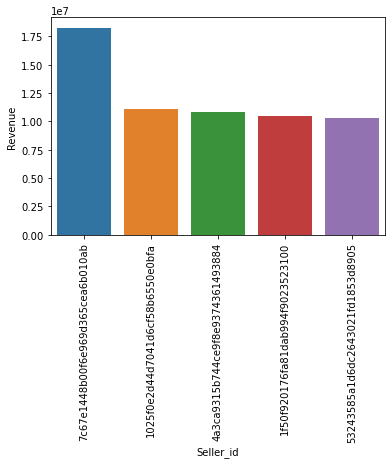

In [16]:
query = """ select * , dense_rank() over(order by revenue desc ) as rn
from 

(select order_items.seller_id,sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id=payments.order_id
group by order_items.seller_id) as a"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data,columns=['Seller_id','Revenue','Rank'])
df.head()
sns.barplot(x='Seller_id',y='Revenue',data =df.head())
plt.xticks(rotation=90)
plt.show




1. Calculate the moving average of order values for each customer over their order history.

In [17]:
query = """select customer_id,order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data)
df.head()



,0,1,2
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
3,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
4,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998


2. Calculate the cumulative sales per month for each year.

In [18]:
query = """select years,months,payment,sum(payment)
over(order by years,months)cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years,months order by years,months) as a"""
  
cur.execute(query)

data=cur.fetchall()

df = pd.DataFrame(data)
df



,0,1,2,3
0,2016,9,9080.64,9.080640e+03
1,2016,10,2127257.28,2.136338e+06
2,2016,12,706.32,2.137044e+06
3,2017,1,4985569.44,7.122614e+06
4,2017,2,10508688.34,1.763130e+07
5,2017,3,16195089.58,3.382639e+07
6,2017,4,15040369.06,4.886676e+07
7,2017,5,21345077.52,7.021184e+07
8,2017,6,18405949.69,8.861779e+07
9,2017,7,21325785.10,1.099436e+08


Calculate the year-over-year growth rate of total sales.

In [19]:
query = """with a as
(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id=payments.order_id
group by years order by years)
select years,(payment-lag(payment, 1)over(order by years))/
lag(payment, 1)over(order by years)*100
from a"""

cur.execute(query)

data=cur.fetchall()
df = pd.DataFrame(data,columns=['Year','YOY Percentage_Growth'])
df


,Year,YOY Percentage_Growth
0,2016,NaN
1,2017,12112.703759
2,2018,20.000924


4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [21]:
query ="""WITH a AS (
    SELECT 
        c.customer_id,
        MIN(o.order_purchase_timestamp) AS first_order
    FROM customers c
    JOIN orders o 
        ON c.customer_id = o.customer_id
    GROUP BY c.customer_id
),
b AS (
    SELECT 
        a.customer_id,
        COUNT(DISTINCT o.order_purchase_timestamp) AS next_order
    FROM a
    JOIN orders o 
        ON o.customer_id = a.customer_id
       AND o.order_purchase_timestamp > a.first_order
       AND o.order_purchase_timestamp < DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)
SELECT 
    100 * COUNT(DISTINCT b.customer_id) / COUNT(DISTINCT a.customer_id) AS repeat_rate_percentage
FROM a
LEFT JOIN b 
    ON a.customer_id = b.customer_id;
"""

cur.execute(query)

data=cur.fetchall()
data

[(Decimal('0.0000'),)]

## No repeated customer

5. Identify the top 3 customers who spent the most money in each year.

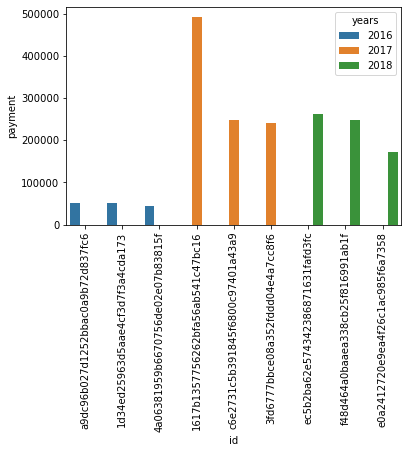

In [25]:
query = """select years,customer_id,payment,D_Rank
from

(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) D_Rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where D_Rank<=3"""

cur.execute(query)
data=cur.fetchall()
df = pd.DataFrame(data,columns=['years','id','payment','rank'])
sns.barplot(x='id',y='payment',data=df,hue='years')
plt.xticks(rotation=90)
plt.show()